In [1]:
from ogb.nodeproppred import PygNodePropPredDataset
from ogb.nodeproppred import Evaluator

import torch
from torch import nn
from torch import Tensor
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

import torch_geometric.data as pyg_data
from torch_geometric.data import DataLoader
from torch_geometric.data import Batch
from torch_geometric.data import DataListLoader
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils
import torch_geometric.transforms as T

import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)
print(torch.__version__)

Device available for running: 
cuda:1
1.10.1


In [3]:
torch.use_deterministic_algorithms(False)
torch.manual_seed(0)
modelPath = "BestArxivPredNode.mdl"

In [4]:
dataset = PygNodePropPredDataset(name='ogbn-arxiv', transform=T.ToSparseTensor())
split_idx = dataset.get_idx_split()
train_idx, dev_idx, test_idx = split_idx["train"].to(device), split_idx["valid"].to(device), split_idx["test"].to(device)
graph = dataset[0]
graph.adj_t = graph.adj_t.to_symmetric().to(device)
graph.x = graph.x.float().to(device)
graph.y = graph.y.to(device)


In [5]:
evaluator = Evaluator(name = "ogbn-arxiv")
outputchan = graph.y.max().item()+1
print(outputchan)
model = pyg_nn.GraphSAGE(in_channels= 128, hidden_channels= 256, out_channels = outputchan, num_layers= 3, dropout = 0.5)
model = model.to(device)
opt = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

bestDevScore = -1
devScore=[]
losstab=[]

for epoch in range(1000):
        
        #Train Model        
        model.train()        
        opt.zero_grad()
        pred = model(graph.x,graph.adj_t)
        label = graph.y

        # Mask node
        pred = torch.index_select(pred, 0, train_idx)
        label = torch.index_select(label, 0, train_idx)
        
        loss = loss_fn(pred,label.view(-1)) 
        loss.backward()
        opt.step()
        losstab.append(loss)
        
        
        #Evaluate on dev
        model.eval()
        pred = model(graph.x,graph.adj_t)
        label = graph.y
        
        # Mask node
        pred = torch.index_select(pred, 0, dev_idx)
        label = torch.index_select(label, 0, dev_idx)
        
        pred = pred.argmax(dim=1)
        result_dict = evaluator.eval({"y_true": pred.view(-1,1).long(), "y_pred": label.long()})
        devScore.append(result_dict['acc'])
        if bestDevScore < result_dict['acc']:
            bestDevScore = result_dict['acc']
            torch.save(model.state_dict(),modelPath)
            
        if epoch % 50 == 0:
            print(loss)
            print(epoch,": ", result_dict)
     

40
tensor(3.7181, device='cuda:1', grad_fn=<NllLossBackward0>)
0 :  {'acc': 0.07627772744051814}
tensor(1.4369, device='cuda:1', grad_fn=<NllLossBackward0>)
50 :  {'acc': 0.6299540253028625}
tensor(1.1819, device='cuda:1', grad_fn=<NllLossBackward0>)
100 :  {'acc': 0.6792845397496561}
tensor(1.1022, device='cuda:1', grad_fn=<NllLossBackward0>)
150 :  {'acc': 0.6912312493707843}
tensor(1.0647, device='cuda:1', grad_fn=<NllLossBackward0>)
200 :  {'acc': 0.7000570488942582}
tensor(1.0384, device='cuda:1', grad_fn=<NllLossBackward0>)
250 :  {'acc': 0.7022718883183999}
tensor(1.0260, device='cuda:1', grad_fn=<NllLossBackward0>)
300 :  {'acc': 0.7037148897614014}
tensor(1.0029, device='cuda:1', grad_fn=<NllLossBackward0>)
350 :  {'acc': 0.7095204537065002}
tensor(0.9925, device='cuda:1', grad_fn=<NllLossBackward0>)
400 :  {'acc': 0.7031779589919125}
tensor(0.9757, device='cuda:1', grad_fn=<NllLossBackward0>)
450 :  {'acc': 0.7135809926507601}
tensor(0.9663, device='cuda:1', grad_fn=<NllLossB

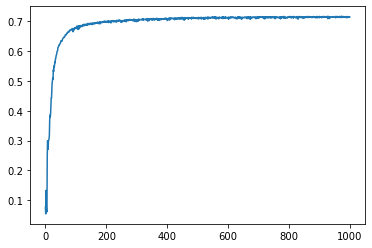

In [6]:
plt.plot(devScore)

In [7]:
model = pyg_nn.GraphSAGE(in_channels= 128, hidden_channels= 256, out_channels = outputchan, num_layers= 3, dropout = 0.5)
model.load_state_dict(torch.load(modelPath))
model = model.to(device)

model.eval()
pred = model(graph.x,graph.adj_t)
label = graph.y
# Mask node
pred = torch.index_select(pred, 0, dev_idx)
label = torch.index_select(label, 0, dev_idx)
pred = pred.argmax(dim=1)
result_dict = evaluator.eval({"y_true": pred.view(-1,1).long(), "y_pred": label.long()})
print("Dev score:", result_dict["acc"])

model.eval()
pred = model(graph.x,graph.adj_t)
label = graph.y
# Mask node
pred = torch.index_select(pred, 0, test_idx)
label = torch.index_select(label, 0, test_idx)
pred = pred.argmax(dim=1)
result_dict = evaluator.eval({"y_true": pred.view(-1,1).long(), "y_pred": label.long()})
print("Test score:", result_dict["acc"])

Dev score: 0.7175744152488338
Test score: 0.7081044379976544
